# Homework 3

# Part 2

In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")

## Question 1 (Summary Statistics)

### 1a.

In [10]:
data = pd.read_excel('barnstable_analysis_data.xlsx', sheet_name = 'data')

data.set_index('date', inplace = True)

data

FileNotFoundError: [Errno 2] No such file or directory: 'barnstable_analysis_data.xlsx'

In [11]:
log_data = pd.DataFrame()

log_data['SPX'] = np.log(1 + data['SPX'])
log_data['TB1M'] = np.log(1 + data['TB1M'])
log_data.index = data.index

log_data

,SPX,TB1M
date,,
1926-01-30,-0.001785,0.003057
1926-02-27,-0.033863,0.002609
1926-03-31,-0.059440,0.002598
1926-04-30,0.037799,0.002268
1926-05-28,0.013531,0.002688
...,...,...
2021-04-30,0.052503,0.000004
2021-05-28,0.006189,0.000004
2021-06-30,0.023406,0.000030


In [12]:
def summ(df, yr_lower, yr_higher):
    df_rev = df.loc[yr_lower:yr_higher]
    rm = df_rev['SPX'].mean() * 12
    rf = df_rev['TB1M'].mean() * 12
    rm_tilde = rm - rf
    
    volm = df_rev['SPX'].std() * np.sqrt(12)
    volm_tilde = (df_rev['SPX'] - (0.06/12)).std() * np.sqrt(12)
    volf = df_rev['TB1M'].std() * np.sqrt(12)
    
    rets = pd.Series([rm, rm_tilde, rf])
    vols = pd.Series([volm, volm_tilde, volf])
    
    summ_table = pd.DataFrame({'Mean' : rets, 'Vol' : vols})
    summ_table.index = ['rm', 'rm_tilde', 'rf']
    
    return summ_table

In [13]:
summ_1999 = summ(data, '1965', '1999')
summ_2021 = summ(data, '2000', '2021')
summ_full = summ(data, '1926', '2021')

summ_norm = pd.concat([summ_1999, summ_2021, summ_full], axis = 1)
summ_norm.columns = ['99 Mean', '99 Vol', '21 Mean', '21 Vol', 'Full Mean', 'Full Vol']

summ_norm

,99 Mean,99 Vol,21 Mean,21 Vol,Full Mean,Full Vol
rm,0.129354,0.149404,0.083958,0.149900,0.115692,0.187193
rm_tilde,0.067851,0.149404,0.069255,0.149900,0.083883,0.187193
rf,0.061503,0.007179,0.014703,0.005038,0.031809,0.008581


In [14]:
lsumm_1999 = summ(log_data, '1965', '1999')
lsumm_2021 = summ(log_data, '2000', '2021')
lsumm_full = summ(log_data, '1926', '2021')

summ_log = pd.concat([lsumm_1999, lsumm_2021, lsumm_full], axis = 1)
summ_log.index = ['log rm', 'log rm_tilde', 'log rf']
summ_log.columns = ['99 Mean', '99 Vol', '21 Mean', '21 Vol', 'Full Mean', 'Full Vol']

summ_log

,99 Mean,99 Vol,21 Mean,21 Vol,Full Mean,Full Vol
log rm,0.117600,0.149568,0.072420,0.151027,0.097888,0.186459
log rm_tilde,0.056279,0.149568,0.057738,0.151027,0.066158,0.186459
log rf,0.061320,0.007132,0.014681,0.005028,0.031730,0.008546


In [15]:
table = pd.concat([summ_norm, summ_log], axis = 0)

In [16]:
indices = [
    np.array(['normal','normal','normal','log','log','log']),
    np.array(['rm','rm_tilde','rf','rm', 'rm_tilde', 'rf']),
]

In [17]:
table.index = indices

In [18]:
table

99 Mean    99 Vol   21 Mean    21 Vol  Full Mean  Full Vol
normal rm        0.129354  0.149404  0.083958  0.149900   0.115692  0.187193
       rm_tilde  0.067851  0.149404  0.069255  0.149900   0.083883  0.187193
       rf        0.061503  0.007179  0.014703  0.005038   0.031809  0.008581
log    rm        0.117600  0.149568  0.072420  0.151027   0.097888  0.186459
       rm_tilde  0.056279  0.149568  0.057738  0.151027   0.066158  0.186459
       rf        0.061320  0.007132  0.014681  0.005028   0.031730  0.008546

The earlier subsample has much higher mean returns, but similar excess returns due to the notable decrease in rf.
The log returns show lower mean returns as expected.

## Question 2

### 2a.

In [22]:
def prob_calc(h, tilde_mu, tilde_sigma):
    return norm.cdf(- np.sqrt(h) * tilde_mu / tilde_sigma)

def prob(h, tilde_mu, tilde_sigma):
    prob_df = pd.DataFrame(data = h, columns = ['h'])
    
    prob_df['Probability'] = prob_calc(prob_df['h'], tilde_mu, tilde_sigma)
    
    prob_df = prob_df.set_index('h')
    
    return prob_df

mu_tilde = table.iloc[4, 0]
sigma_tilde = table.iloc[4, 1]
h = 2021 - 1999
prob(list(range(5,35, 5)), mu_tilde, sigma_tilde)

,Probability
h,
5,0.200065
10,0.117042
15,0.072513
20,0.046209
25,0.029958
30,0.019653


### 2b.

In [26]:
prob([10, 30], mu_tilde, sigma_tilde)

,Probability
h,
10,0.117042
30,0.019653


### 2c.

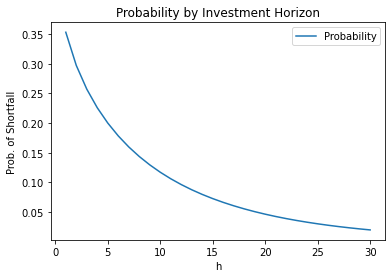

In [27]:
prob_horizon = prob(list(range(1, 31)), mu_tilde, sigma_tilde)

prob_horizon.plot() 
plt.title('Probability by Investment Horizon')
plt.ylabel('Prob. of Shortfall')
plt.show()

## Question 3

In [29]:
log_df1965 = log_data.loc['1965':].dropna()
mu_tilde = (log_df1965['SPX'].mean()-log_df1965['TB1M'].mean()) * 12
sigma_tilde = (log_df1965['SPX']-log_df1965['TB1M']).std() * np.sqrt(12)

prob(list(range(5,35, 5)), mu_tilde, sigma_tilde)

,Probability
h,
5,0.197606
10,0.114610
15,0.070430
20,0.044527
25,0.028643
30,0.018645


In [30]:
prob([30], mu_tilde, sigma_tilde)

,Probability
h,
30,0.018645


In [31]:
prob([2021-1999], mu_tilde, sigma_tilde)

,Probability
h,
22,0.03726


## Question 4

### 4a.

In [32]:
mu = stats_df.iloc[3,0]
bar_r = stats_df.iloc[3,2]
sigma = stats_df.iloc[3,1]

prob([22], mu - bar_r, sigma)

,Probability
h,
22,0.078265


### 4b.

In [33]:
strike = np.log(1.06)

mu65 = log_df1965['SPX'].mean() * 12

sigma65 = log_df1965['SPX'].std() * np.sqrt(12)

mu = 22/8 * (stats_df.iloc[3, 2] - strike) + mu65 - strike

prob([8], mu, sigma65)

,Probability
h,
8,0.062614


# Part 3

# 1.a

In [36]:
mu_tilde = data.SPX - data.TB1M

Text(0.5, 1.0, 'Historical VaR')

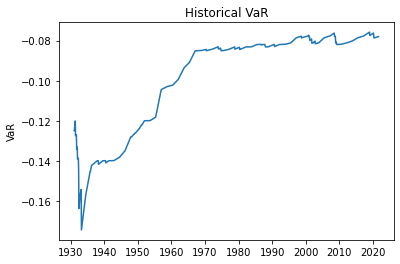

In [37]:
var_hist = mu_tilde.shift(1).expanding(60).quantile(0.05).dropna()
plt.plot(var_hist)
plt.ylabel('VaR')
plt.title("Historical VaR")

# 1.b

In [39]:
freq = len(var_hist[mu_tilde[60:]<var_hist])
print("Frequency of r_tilde < r_tilde_var: %d" %freq)
less_var = np.round(freq/len(var_hist.index),5)
print('% of returns less than VaR: ', less_var*100)

Frequency of r_tilde < r_tilde_var: 31
% of returns less than VaR:  2.849


# 1.c

By definition of VaR, number instances of return should be less than VaR (5%) should be close to 5%, but in our case it is less than 3%
This method of calculation is valid if there is a smooth tail, and does not give correct result if tails are not smooth

## Question 2

### 2a.

In [ ]:
stdev = np.sqrt((df[r'$\tilde{r}$']**2).shift(1).expanding(60).mean().to_frame('Expanding Window'))

stdev['Rolling Window'] = np.sqrt((df[r'$\tilde{r}$']**2).shift(1).rolling(60).mean())

In [48]:
IGARCH = arch_model(df[r'$\tilde{r}$'])

theta = 0.97

IGARCH.volatility = EWMAVariance(theta)

IGARCH_model = IGARCH.fit()

IGARCH_model.params

In [49]:
GARCH = arch_model(df[r'$\tilde{r}$'], vol='Garch', p=1, o=0, q=1, dist='Normal')

GARCH_model = GARCH.fit()

GARCH_model.params

In [ ]:

stdev[['GARCH','EWMA']] = None

### Initialize with the given parameter
stdev.iloc[0,2:] = 0.15

### Simulate the rest of the period using the initial stdev given
for i in range(1, len(stdev)):
    ### Forecast variance by plugging the GARCH and IGARCH parameters into their respective equations
    stdev['EWMA'].iloc[i] = np.sqrt((stdev['EWMA'].iloc[i-1]**2) * theta \
                                    + (1-theta)*(df[r'$\tilde{r}$'].iloc[i-1]**2))
    stdev['GARCH'].iloc[i] = np.sqrt(GARCH_model.params['omega']\
                                     + (stdev['GARCH'].iloc[i-1]**2) * GARCH_model.params['beta[1]']\
                                     + GARCH_model.params['alpha[1]']*(df[r'$\tilde{r}$'].iloc[i-1]**2))
    
stdev.dropna(inplace = True)

stdev.plot()

plt.title('Volatility Forecasts')
plt.ylabel(r'$\sigma_{t}$')
plt.xlabel('Date')
plt.show()

## 2.3 Part(b)


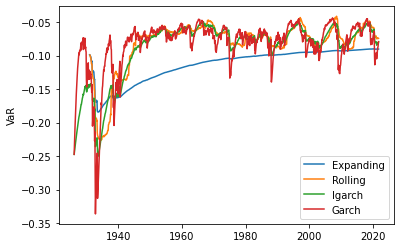

In [57]:
VaR = -1.65 * stdev
VaR.plot()

plt.title('VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

## 2.3 Part (c)

In [60]:
freq_df = pd.DataFrame(index = ['Frequency'], columns = VaR.columns)

for col in freq_df:
    freq_df[col] = len(VaR[df.loc[VaR.index, r'$\tilde{r}$'] < VaR[col]]) / len(VaR[col].dropna().index)
    
round(freq_df, 4)

,Expanding Series,Rolling Window,EWMA,GARCH
Freq < VaR,0.016551,0.045296,0.041812,0.046167


##### Compared to our historical VaR of 2.84%, [Garch, Rolling Window, EWMA] models all provide realatively close to estimating the 5% threshold. However, the Expanding Series results of 1.6%  underestimat the 5% typical threshhold for VaR. Therefore, we feel Expanding Series is a poor estimator relative to the standard 5% threshhold, much like the Historical VaR.